In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Source

from toolbox.pca_plot import get_variance_percentage, get_number_of_attributes, plot_pca_variance
from toolbox.data_processing import clean_data, get_X_train_and_test_data, merge_train_and_test_data,get_y_train_and_test_data
from toolbox.k_fold_algorithm import k_fold, plot_classification_error
from toolbox.plot_results import get_tree_graph, plot_cm_and_rc
from toolbox.gradient_search import grid_search_classifier

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_tree

ImportError: cannot import name 'load_data' from 'toolbox.data_processing' (C:\Users\459466\Desktop\Datamining\project\toolbox\data_processing.py)

In [2]:
y = pd.read_csv('data/archive/actual.csv', index_col = 'patient')
X_train = pd.read_csv('data/archive/data_set_ALL_AML_train.csv')
X_test = pd.read_csv('data/archive/data_set_ALL_AML_independent.csv')
y.head()

,cancer
patient,
1,ALL
2,ALL
3,ALL
4,ALL
5,ALL


In [3]:
# Sort the indexes
#train.index = pd.to_numeric(train.index) 
#test.index = pd.to_numeric(test.index)
#y.index = pd.to_numeric(y.index)
#train.sort_index(inplace=True) 
#test.sort_index(inplace=True)
#y.sort_index(inplace=True)


#X_train, X_test = get_X_train_and_test_data(train, test)

In [4]:
# Clean all the data
# Drop the call collumns from both data sets
call_cols_train = [col for col in X_train.columns if 'call' in col]
X_train = X_train.drop(call_cols_train, axis = 1)

call_cols_test = [col for col in X_test.columns if 'call' in col]
X_test = X_test.drop(call_cols_test, axis = 1)

# Drop "Gene Description" and "Gene Accession Number"
cols_to_drop = ['Gene Description', 'Gene Accession Number']
X_train = X_train.drop(cols_to_drop, axis = 1)
X_test = X_test.drop(cols_to_drop, axis = 1)

# Transpose both data_sets
X_train = X_train.T
X_test = X_test.T

# now clean the patient_data
y = y.replace({'ALL': 0, 'AML': 1})
y_train = y[y.index <= 38]
y_test = y[y.index > 38]

# Define labels to use in our decission tree later.
patient_labels = ['ALL', 'AML']

In [5]:
# Sort the indices in the data sets
X_train.index = pd.to_numeric(X_train.index) 
X_test.index = pd.to_numeric(X_test.index) 
X_train.sort_index(inplace=True) 
X_test.sort_index(inplace=True)

# Reset the indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)

X_train = X_train.replace(np.inf, np.nan)
X_train = X_train.fillna(value = X_train.values.mean())

X_test = X_test.replace(np.inf, np.nan)
X_test = X_test.fillna(value = X_train.values.mean())

#
y = y.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [6]:
# PCA
pca = PCA()
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)
pca_complete = np.append(pca_train, pca_test, 0)

# Stack explained variance
pca_variance_ratio = pca.explained_variance_ratio_.cumsum()
pca_variance_percentage = pca_variance_ratio*100

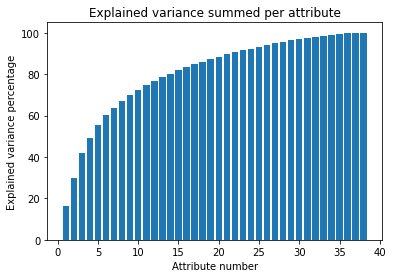

Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.
There are 21 attributes that together explain 90% of the variance.


In [7]:
# Plot explained variance PCA
plt.bar(range(1,pca_variance_percentage.size+1), pca_variance_percentage)
plt.title("Explained variance summed per attribute")
plt.xlabel("Attribute number")
plt.ylabel("Explained variance percentage")
plt.show()
print('''Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.''')

#Determine number of attributes needed for an explained variance of 90%
pca_variance_cropped = [i for i in pca_variance_percentage if i <= 90]
no_attributes = len(pca_variance_cropped)
print("There are {} attributes that together explain 90% of the variance." .format(no_attributes))

In [8]:
#Crop pca_data for the useful number of attributes
pca_data = np.delete(pca_complete, slice(no_attributes, len(pca_complete)) , 1)
print(no_attributes)
#Split data back to original train and test split
X_train_pca = pca_complete[:38]
X_test_pca = pca_complete[38:]
y = y.ravel()

21


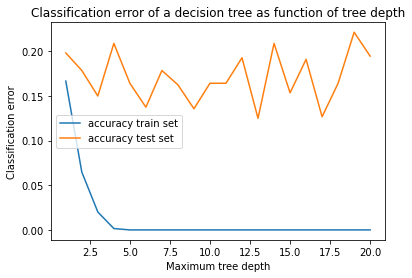

In [9]:
accuracy_mean_train_tree, accuracy_mean_test_tree = k_fold(pca_data, y, 10, 1, 21, 1, 'tree')
plot_classification_error(1, 21, 1, accuracy_mean_train_tree, accuracy_mean_test_tree, 'tree depth')

In [10]:
parameters_tree = {
    'max_depth' : [2, 4, 6, 'None'],
    'min_samples_leaf' : [2, 4, 6],
    'criterion' : ['gini', 'entropy'],
    'random_state' : ['None', 10, 42]
}

predictions_tree, dtc = grid_search_classifier('tree', parameters_tree, X_train_pca, X_test_pca, y_train, y_test)

The best parameters for this model are: 
DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=4,
                       random_state=10)
This gives an accuracy of 0.7941176470588235 and an error of 0.20588235294117652


In [11]:
#tree_complete = tree.DecisionTreeClassifier(criterion='gini', max_depth = 4, min_samples_leaf=5)
tree_complete = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=10)
tree_complete = tree_complete.fit(pca_train, y_train)
prediction_complete=tree_complete.predict(pca_test)
accuracy_complete = metrics.accuracy_score(y_test, prediction_complete)
print("The standard decision tree has an accuracy of {} and an error rate of {}.".format(accuracy_complete, 1-accuracy_complete))

The standard decision tree has an accuracy of 0.7941176470588235 and an error rate of 0.20588235294117652.


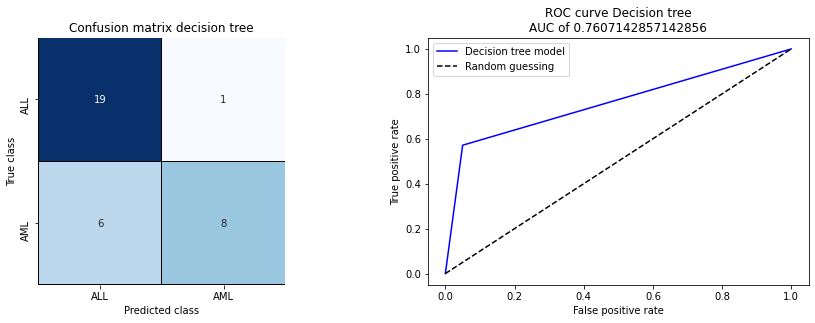

In [12]:
# Function for plotting the confusion matrices
conf_matrix_tree = metrics.confusion_matrix(y_test, predictions_tree)
plot_cm_and_rc(conf_matrix_tree, patient_labels,y_test, predictions_tree,'Decision tree', 'Confusion matrix decision tree')

In [16]:
no_attributes

21

In [18]:
graph = get_tree_graph(tree_complete, 0, 21, patient_labels)
graph

ValueError: Length of feature_names, 21 does not match number of features, 38